In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/ml_data"
%cd /content/drive/My Drive/ml_data/cv/Faces/FER/FER_modified

Mounted at /content/drive
/content/drive/My Drive/ml_data/cv/Faces/FER/FER_modified


In [ ]:
#!kaggle datasets download -d srinivasbece/fer-modified --force 

In [ ]:
import torch 
import torch.nn as nn

from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torchvision.models as models
from torch.utils.data import Dataset
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import cv2
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import os
from google.colab.patches import cv2_imshow
import pandas as pd
from sklearn.model_selection import train_test_split

torch.manual_seed(2)

In [ ]:
transformations_train = transforms.Compose([
    transforms.RandomCrop(48, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transformations_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
root = '/content/drive/My Drive/ml_data/cv/Faces/FER/FER_modified'
train = datasets.ImageFolder(root+'/train',transform=transformations_train)
test = datasets.ImageFolder(root+'/test',transform=transformations_val)

train_loader = torch.utils.data.DataLoader (train, batch_size = 128, shuffle = True,pin_memory=True)
val_loader = torch.utils.data.DataLoader (test, batch_size = 128, shuffle = False,pin_memory=True)

In [ ]:
dataiter = iter(train_loader)
images,labels = dataiter.next()
images.shape, labels.shape

(torch.Size([128, 3, 48, 48]), torch.Size([128]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

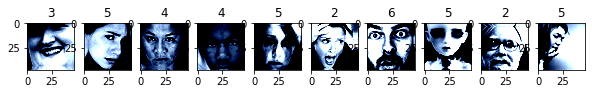

In [ ]:
f,axes = plt.subplots(1,10,figsize=(10,10))
for i,axis in enumerate(axes):
  # поэтому вы можете преобразовать форму numpy ndarray в тензор в PyTorch (H, W, C) --> (C, H, W)
  axes[i].imshow(np.squeeze(np.transpose(images[i].numpy(), (1, 2, 0))), cmap='gray')
  axes[i].set_title(labels[i].numpy())
plt.show()

# Model

In [ ]:
device = torch.device('cuda')

# Resnet-9

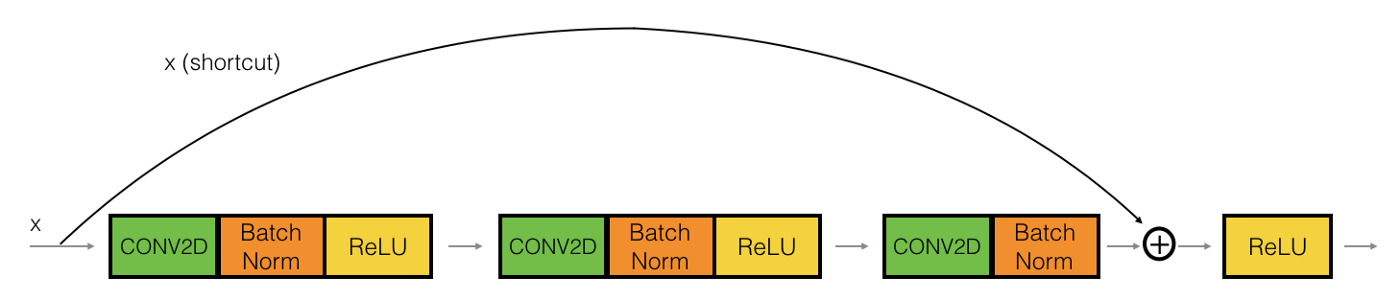

In [ ]:
def conv_block(in_channels, out_channels, pool=False, pool_no=3):
  layers = [nn.Conv2d(in_channels, out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
  ]
  if pool:
    layers.append(nn.MaxPool2d(pool_no))
  return nn.Sequential(*layers)

  

In [ ]:
class Resnet(nn.Module):
  def __init__(self,in_channels,num_classes):
    super().__init__()
    self.conv1 = conv_block(in_channels,64)
    self.conv2 = conv_block(64,128,pool=True)
    self.res1 = nn.Sequential(conv_block(128,128),conv_block(128,128))
    self.conv3 = conv_block(128,256)
    self.conv4 = conv_block(256,512)
    self.res2= nn.Sequential(conv_block(512,512),conv_block(512,512))
    self.classifier = nn.Sequential(
                                    nn.Flatten(),
                                    nn.Linear(512*16*16,512),
                                    nn.Linear(512,num_classes)
    )
  def forward(self,x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    #print(out.shape)
    out = self.classifier(out)
    return out

In [ ]:
def train(net, n_epoch=8):
    # выбираем функцию потерь
    loss_fn = torch.nn.CrossEntropyLoss()

    # выбираем алгоритм оптимизации и learning_rate
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # acc по test
    best_accuracy = 0
    # обучаем сеть 2 эпохи
    for epoch in tqdm(range(n_epoch)):

        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(tqdm(train_dataiter)):
            # так получаем текущий батч
            X_batch, y_batch = batch
            # переносим его на видеопамять
            # если точно уверены, что это гпу - можно написать .cuda()
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # обнуляем веса
            optimizer.zero_grad()

            # forward pass (получение ответов на батч картинок)
            y_pred = net(X_batch)
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(y_pred, y_batch)
            # bsckpropagation (вычисление градиентов)
            loss.backward()
            # обновление весов сети
            optimizer.step()

          
            if i % 1500 ==0:
                # менеджер упарвления контекстом торча указывает на то, чтобы не обновлять параметры
                with torch.no_grad():
                    accuracy = []
                    for batch in val_loader:
                        x, y = batch
                        # переносим на гпу
                        x = x.to(device)
                        y = y.to(device)
                        # прогнозируем
                        y_pred = net(x)
                        # loss = loss_fn(y_pred, y)
                        # находим accuracy батча с теста
                        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
                    # усредняем accuracy всех батчей на тесте
                    accuracy = np.mean(np.array(accuracy))
                    # если стало лучше - сохраняем на диск и обновляем лучшую метрику
                    if accuracy > best_accuracy:
                        print('New best model with test acc:', accuracy)
                        torch.save(net.state_dict(), './best_model.pt')
                        best_accuracy = accuracy

            # выведем текущий loss
            running_loss += loss.item()
            
            if i % 200 == 199:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 500))
                running_loss = 0.0

    print('Обучение закончено')
    return net

In [ ]:
# model = Resnet(3, 7).to(device)
# train(model)

In [ ]:
model = Resnet(3, 7).to(device)
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

Resnet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, mo

In [ ]:
dataiter = iter(val_loader)
images,labels = next(dataiter)
images,labels = images.to(device),labels.to(device)
output = model(images)
images = images.cpu()

In [ ]:
# преобразовать выходные вероятности в предсказанный класс
_, preds_tensor = torch.max(output, 1)
# предсказанные картинки
preds = np.squeeze(preds_tensor.cpu().numpy())
print(preds)

[3 2 0 3 0 3 4 5 5 2 2 3 4 0 6 4 5 4 3 3 6 4 2 4 3 3 2 6 3 6 5 5 4 4 4 4 4
 4 3 3 4 0 4 6 6 3 5 5 4 6 5 5 6 5 6 3 6 3 4 5 4 0 3 4 6 3 3 6 4 6 3 6 2 4
 3 6 4 6 0 4 2 3 5 3 3 4 3 6 5 3 4 5 6 5 4 5 4 6 2 5 4 6 6 3 0 4 3 3 6 5 3
 3 5 6 4 3 4 2 2 0 3 3 0 4 5 3 5 5]


In [ ]:
classes = [0,1,2,3,4,5,6 ]

translate = {0:'Angry', 1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

#facial expressions: 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Neutral, 5=Sad, 6=Surprise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

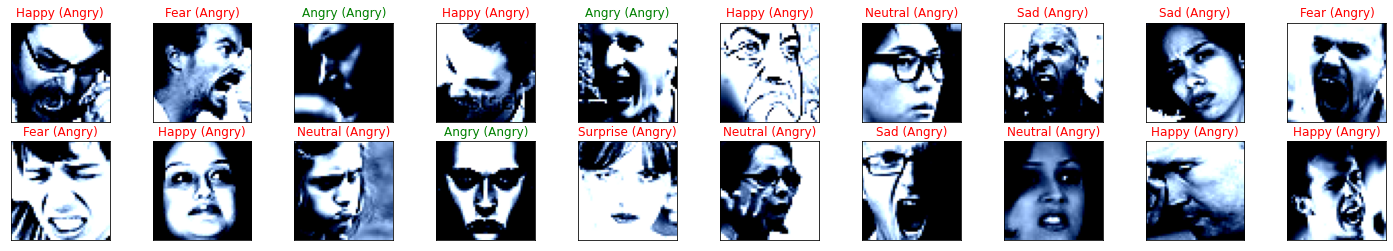

In [ ]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(translate[classes[preds[idx]]], translate[classes[labels[idx]]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))